#### Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import unquote

import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Load and transform data

In [2]:
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', sep='\t', skiprows=12, header=None)
articles.columns = ['article_names']

paths_finished = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', skiprows=17, header=None)
paths_finished.columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']

paths_unfinished = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', sep='\t', skiprows=17, header=None)
paths_unfinished.columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']


In [3]:
def utf_transform(data, column_path):
    ''' Function that decode the name of articles in the dataframe'''
    for index, row in data.iterrows():
        row[column_path] = unquote(row[column_path], encoding='utf-8') 

In [4]:
utf_transform(articles, 'article_names')
utf_transform(paths_finished, 'path')
utf_transform(paths_unfinished, 'path')

## Relate the position of links with the duration of the game

**Q** Does clicking on links lower down in the article increase the duration of the game compared to clicking on links higher up in the article? 

In [5]:
def link_position(data, column_path):
    ''' Function that compute the relative position of the links in the articles and the average link
        position for each paths 
        column_path: name of the column in the dataframe where the paths are stored '''
    
    link_position = data.copy()
    link_position['link_positions'] = np.nan      #Store the positions of all links browsed along the path
    link_position['avg_link_positions'] = np.nan  #Average position of links 
            
    for index, row in data.iterrows():
        path = row[column_path]
        path = path.split(';')

        if '<' not in path:   #Consider the path where the user don't back clicks 
            positions = []    #List to store the position of each link in the considered path

            for article in path[:len(path)-1]:
                path_article = 'plaintext_articles/' + article + '.txt' 

                # First, compute the number of words in the article (for the relative position)
                with open(path_article, 'r') as fp: #Open the plaintext article
                    all_text = fp.read()
                    all_words = all_text.split()
                    nb_words = len(all_words)

                # Second, read each line and find the link of the next article
                with open(path_article, 'r') as fp:
                    lines = fp.readlines()
                    for line in lines:
                        word = path[path.index(article)+1] #Find the position of the link of the next article
                        word = word.replace('_', ' ')      #If article name have '_', it should be replaced by a space

                        #Store the relative position of the first appearance of the link
                        if line.find(word) != -1:
                            positions.append(lines.index(line)/nb_words)
                            break

            link_position.at[index, 'link_positions'] = str(positions)
            link_position.at[index, 'avg_link_positions'] = np.mean(positions)

    # Drop NaN values (if link not found)
    link_position = link_position.dropna()

    return link_position

#### Finished paths

In [6]:
# Compute the link positions
finished_path_link_position = link_position(paths_finished, 'path')

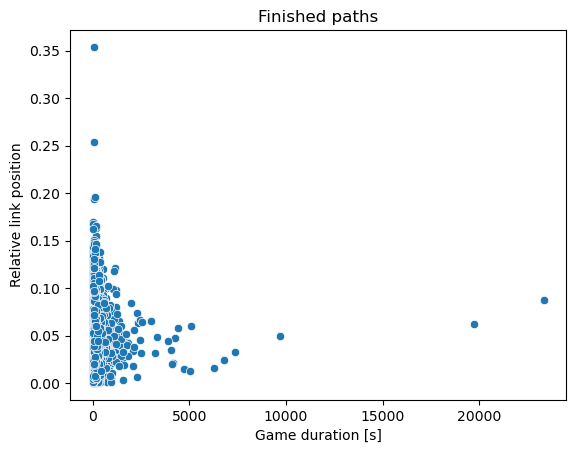

In [7]:
# Check if duration of the path played is related to the relative position of links
sns.scatterplot(x='durationInSec', y='avg_link_positions', data=finished_path_link_position)
plt.xlabel('Game duration [s]')
plt.ylabel('Relative link position')
plt.title('Finished paths');

#### Unfinished paths

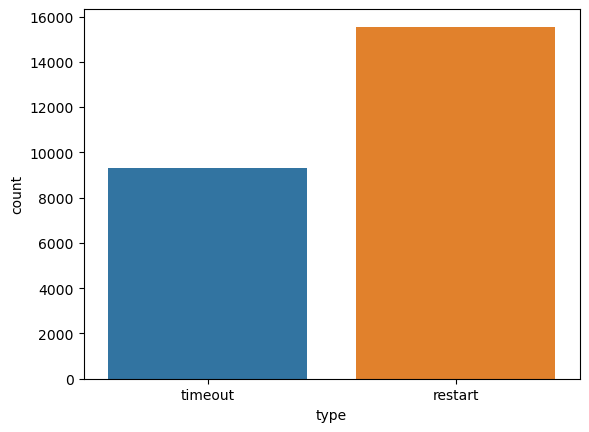

In [8]:
# Type of unfinished paths
sns.countplot(paths_unfinished, x="type");

In [9]:
# Compute the link positions for 'timeout' type
timeout_link_position = link_position(paths_unfinished[paths_unfinished['type']=='timeout'], 'path')
# Link position for 'restart' type
restart_link_position = link_position(paths_unfinished[paths_unfinished['type']=='restart'], 'path')

Text(0.02, 0.5, 'Relative link position')

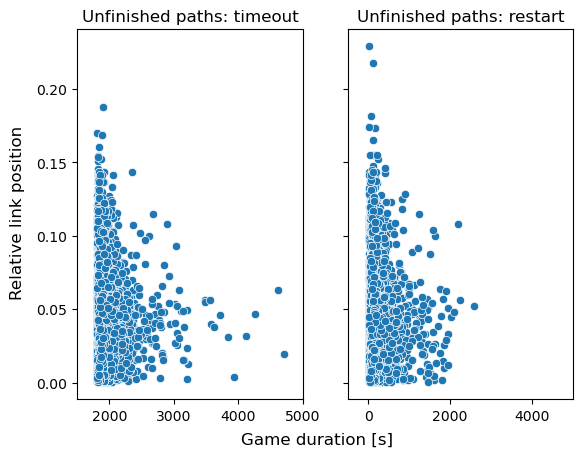

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.scatterplot(x='durationInSec', y='avg_link_positions', data=timeout_link_position, ax=ax1)
ax1.set_title('Unfinished paths: timeout')
ax1.set_xlim([1500, 5000])
ax1.set_xlabel('')
ax1.set_ylabel('')

sns.scatterplot(x='durationInSec', y='avg_link_positions', data=restart_link_position, ax=ax2)
ax2.set_title('Unfinished paths: restart');
ax2.set_xlim([-500, 5000])
ax2.set_xlabel('')

fig.supxlabel('Game duration [s]')
fig.supylabel('Relative link position')


## Position of links for players that have done multiple games

**Q** Do players who have finished multiple paths tend to choose the first links, or do they go further into the article? 

In [11]:
# Select players that have finished between 25 and 100 games
multiple_players = finished_path_link_position.value_counts('hashedIpAddress')
multiple_players = multiple_players[(multiple_players>25) & (multiple_players<100)].to_frame().reset_index()

In [12]:
# Compute the average link position of all the paths finished by 'multiple' players
multiple_players_link_position = finished_path_link_position[finished_path_link_position['hashedIpAddress'] \
                                 .isin(multiple_players['hashedIpAddress'])]
multiple_players_mean_link_position = multiple_players_link_position.groupby('hashedIpAddress')['avg_link_positions'] \
                                    .mean().to_frame().reset_index()
multiple_players_stat = pd.merge(multiple_players, multiple_players_mean_link_position, on='hashedIpAddress')

# Compute the global average link position of all the paths ever finished
average_link_position = finished_path_link_position['avg_link_positions'].mean()

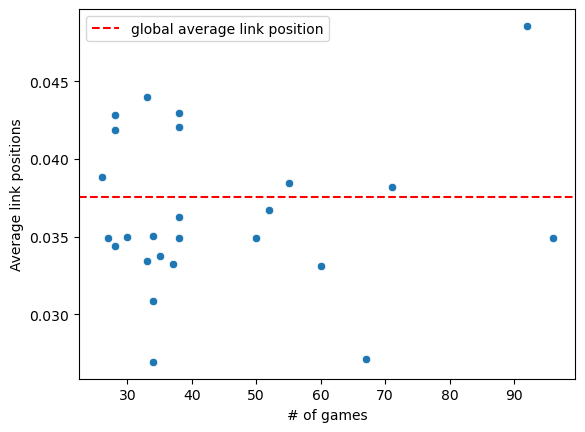

In [17]:
sns.scatterplot(data=multiple_players_stat, x="count", y="avg_link_positions")
plt.axhline(average_link_position, color='r', linestyle='--', label='global average link position')
plt.xlabel('# of games')
plt.ylabel('Average link positions')
plt.legend();

**Q** Does a player who have finished multiple paths always have the same strategy ? (e.g. always go for the first link)

In [14]:
# Select players that have finished more than 10 games
multiple_players = finished_path_link_position.value_counts('hashedIpAddress')
multiple_players = multiple_players[multiple_players>10].to_frame().reset_index()

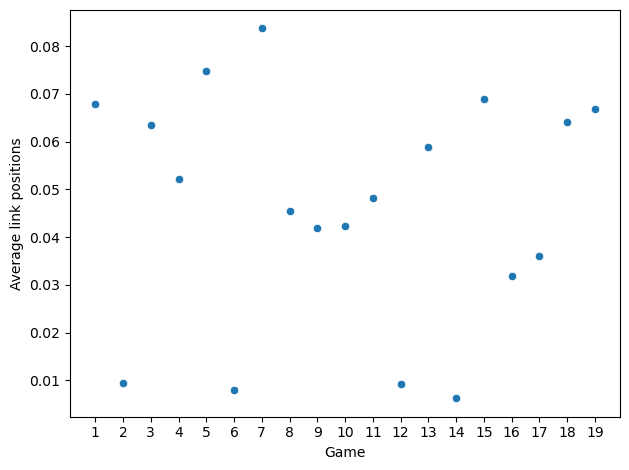

In [15]:
# Among the 'multiple players', select one random
random_player = multiple_players.sample(1)

# Compare the different average link positions of the paths finished by this player
random_player_link_position = finished_path_link_position[finished_path_link_position['hashedIpAddress'] \
                                 .isin(random_player['hashedIpAddress'])]
random_player_link_position['#game'] = np.arange(1,random_player_link_position.shape[0]+1, 1)

# Visualize the results
sns.scatterplot(data=random_player_link_position, x="#game" ,y="avg_link_positions")
plt.xticks(np.arange(1,random_player_link_position.shape[0]+1, 1))
plt.tight_layout()
plt.xlabel('Game')
plt.ylabel('Average link positions');